# elitism

In [1]:
from IPython import get_ipython

In [ ]:
if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc
import latenta as la
import jax
import jax.numpy as jnp
import optax
import tqdm.auto as tqdm
import scipy
import random
import re
import dill as pickle
import sklearn.decomposition
import os
import eyck
from general_functions.model_generation_functions import *
from general_functions.model_visualization_functions import *

/srv/data/robinve/miniconda3/envs/latenta/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# random models
with open("random_model/scores.pkl", "rb") as f:
    scores1 = pickle.load(f)

# partial crossover
with open("partial_crossover/scores.pkl", "rb") as f:
    scores2 = pickle.load(f)

# full crossover
with open("full_crossover/scores.pkl", "rb") as f:
    scores3 = pickle.load(f)

In [5]:
scores1

,index,elbo,elbo_std,lik,penalty,architecture,model_name,generation,initialisation,relative_elbo,relative_lik,relative_penalty
0,0,-70339840.0,0.0,-69840016.0,499824.0,LinCirLinCir,LinCirLinCir_0_0,0,unbiased_initialization,308704.0,654288.0,345616.0
1,1,-70356688.0,0.0,-69724080.0,632608.0,SplSigSplSigCir,SplSigSplSigCir_1_0,0,unbiased_initialization,291856.0,770224.0,478400.0
2,2,-70412664.0,0.0,-70067608.0,345056.0,SigCirLin,SigCirLin_2_0,0,unbiased_initialization,235880.0,426696.0,190848.0
3,3,-70509904.0,0.0,-70213904.0,296000.0,SplLin,SplLin_3_0,0,unbiased_initialization,138640.0,280400.0,141792.0
4,4,-70454856.0,0.0,-69412512.0,1042344.0,SplLinSigLinCirCirCirSplSpl,SplLinSigLinCirCirCirSplSpl_4_0,0,unbiased_initialization,193688.0,1081792.0,888136.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,-70550504.0,0.0,-70126344.0,424160.0,CirCir,CirCir_95_0,0,semi_biased_initialization,98040.0,367960.0,269952.0
196,196,-70397160.0,0.0,-69798512.0,598648.0,CirSplLinCir,CirSplLinCir_96_0,0,semi_biased_initialization,251384.0,695792.0,444440.0
197,197,-70260984.0,0.0,-69682464.0,578520.0,SigCirSplLinSigLin,SigCirSplLinSigLin_97_0,0,semi_biased_initialization,387560.0,811840.0,424312.0
198,198,-70286584.0,0.0,-69413768.0,872816.0,LinSplLinSplSigCirCirLinLin,LinSplLinSplSigCirCirLinLin_98_0,0,semi_biased_initialization,361960.0,1080536.0,718608.0


In [8]:
scores1["initialisation"] = scores1["initialisation"].replace("semi_biased_initialization", "PCA_initialized")
scores2["initialisation"] = scores2["initialisation"].replace("semi_biased_initialization", "PCA_initialized")
scores3["initialisation"] = scores3["initialisation"].replace("semi_biased_initialization", "PCA_initialized")

In [11]:
def boxplot_per_generation(scores_list, labels, y="elbo"):
    """
    Plot ELBO (or other metrics) per generation with combined source and initialization hues.

    Parameters:
    - scores_list: List of dataframes containing the scores and generation information.
    - labels: List of labels corresponding to each dataframe in scores_list.
    - y: Column name for the metric to plot on the y-axis (default: "elbo").
    """
    # Combine all scores dataframes and add a source label
    all_scores = pd.concat(
        [df.assign(source=label) for df, label in zip(scores_list, labels)],
        ignore_index=True
    )

    # Apply the function to count effects for all dataframes
    all_scores["number_of_effects"] = all_scores["architecture"].apply(count_effects)

    # Create a combined label for source and initialization
    all_scores["combined_label"] = all_scores["source"] + " - " + all_scores["initialisation"]

    # Generate a palette for the sources
    source_palette = sns.color_palette("husl", len(labels))  # Unique colors for each label
    source_palette = dict(zip(labels, source_palette))

    # Create a new palette with lighter/darker variations for initialization types
    combined_palette = {}
    for label, base_color in source_palette.items():
        # Generate lighter and darker versions
        combined_palette[label + " - unbiased_initialization"] = sns.light_palette(base_color, n_colors=3)[1]
        combined_palette[label + " - PCA_initialized"] = sns.light_palette(base_color, n_colors=3)[2]

    # Set figure size
    plt.figure(figsize=(14, 8))

    # Create boxplots with the new combined labels as hue
    sns.boxplot(
        x="generation",
        y=y,
        hue="combined_label",  # Use the combined labels
        data=all_scores,
        showfliers=False,
        palette=combined_palette,  # Use the customized palette
        linewidth=1.5,
    )

    # Add a stripplot for additional clarity
    sns.stripplot(
        x="generation",
        y=y,
        hue="combined_label",  # Same hue as boxplot
        data=all_scores,
        dodge=True,
        alpha=0.7,
        marker="o",
        palette=combined_palette,
        jitter=False,
        linewidth=0.2,
        legend=False
    )

    # Customize the legend
    plt.legend(
        title="Crossover - Initialization Type",
        bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10
    )

    # Add titles and labels
    plt.title(f"Genetic algorithm: ELBO per generation", fontsize=16)
    plt.xlabel("Generation", fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


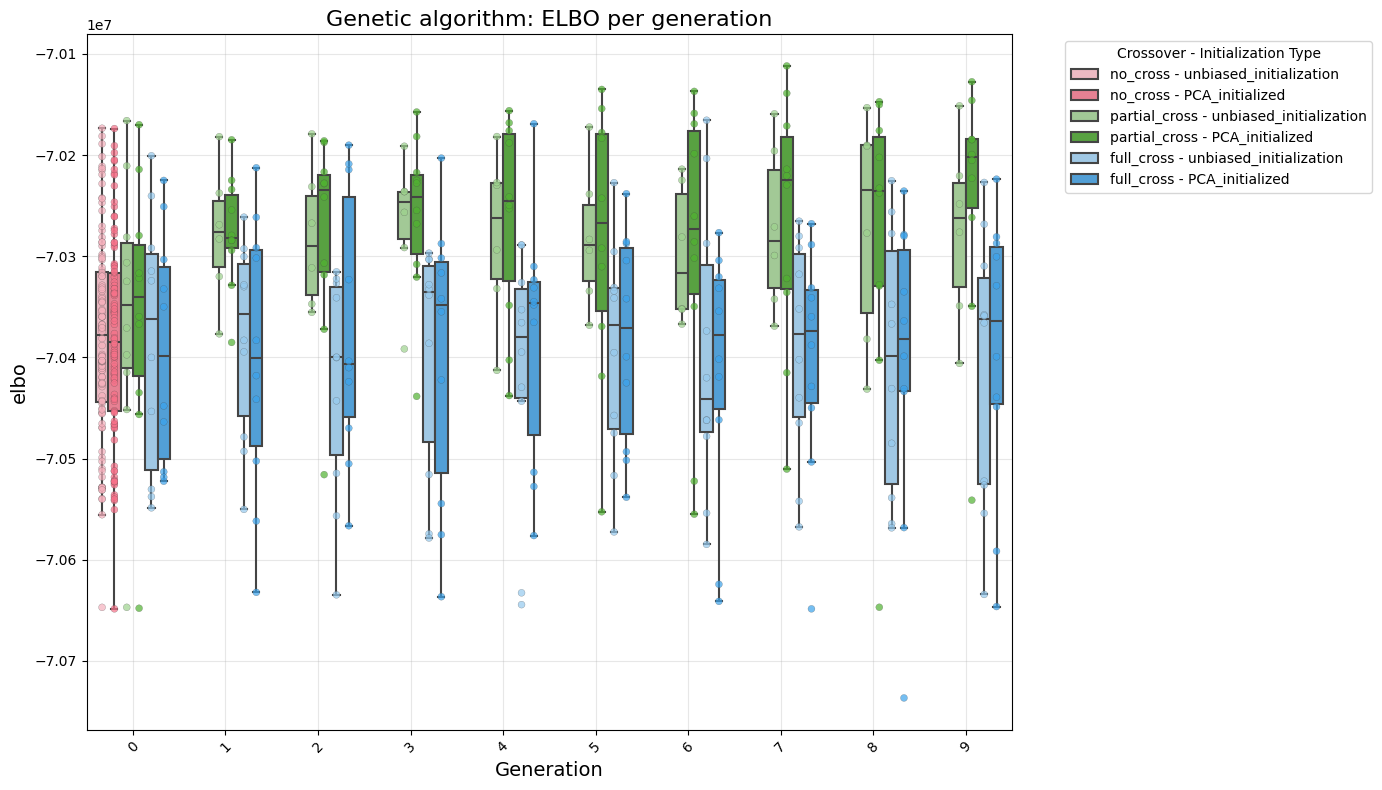

In [12]:
boxplot_per_generation([scores1,scores2,scores3],['no_cross','partial_cross','full_cross'], "elbo")